# Data cleaning and refactoring

In [85]:
# !pip install --upgrade -q pip
# !pip install -q textstat

## Step 1: Importing the required libraries.

In [106]:
# Base libraries.
import os 
import gc
import random
from statistics import median

# Suppress warnings in cells to improve readability
import warnings  
warnings.filterwarnings('ignore')

# Data analysis libraries
import numpy as np 
import pandas as pd 

# This line tells the notebook to show plots inside of the notebook
%matplotlib inline
# Data cisualization libraries
import matplotlib.pyplot as plt
import seaborn as sb

#Textstat is an easy to use library to calculate statistics from text. It helps determine readability, complexity, and grade level.
from textstat import flesch_reading_ease 

# External libraries
from keras.utils import to_categorical
from sklearn.utils import resample

# Connect to Google Drive
from google.colab import drive, files

# Upload Quotes.csv
Upload_File = False
if Upload_File:
  uploaded = files.upload()

In [107]:
# Set key data paths
drive.mount('/content/gdrive')
INPUT_DIR = '/content/gdrive/My Drive/'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [108]:
# Import raw csv data, set column names 
rawDf = pd.read_csv(INPUT_DIR + "Quotes.csv", delimiter=';', header=None, names=['quote', 'author', 'label'])
rawDf.drop(columns="author", inplace=True)
print(f'Dataset orginally has {rawDf.shape[0]} rows')

Dataset orginally has 75966 rows


# Exploratory Data Analysis

In [109]:
# Drop NA data
rawDf = rawDf.dropna()
print(f'Dataset excluding NAs has {rawDf.shape[0]} rows')

Dataset excluding NAs has 75961 rows


## Explore quote complexity

**Flesch Reading Ease (FRE):** Higher scores indicate material that is easier to read, lower numbers mark harder-to-read passages: 
*   0-30 College
*   50-60 High school
*   60+ Fourth grade. 

Calaculated as FRE = 206.835 − 1.015 *(total words/total sentences) − 84.6 * (total syllables/ total words)

In [90]:
def plot_quote_complexity_histogram(quote):
    quote.\
        apply(lambda x : flesch_reading_ease(x)).\
        hist()

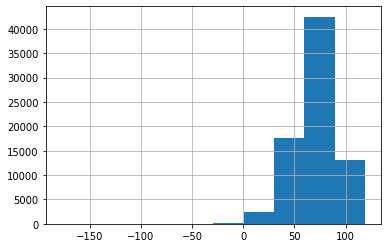

In [91]:
plot_quote_complexity_histogram(rawDf['quote'])

On the x-axis most quotes have a score between 50 - 100. So the average high school student can read and understand them.

In [92]:
def createCategoryDf(df):
  # group by category, count distinct subreddits and posts
  cat_df = df.groupby('label') \
            .agg({'quote': pd.Series.nunique,
                  'quote': pd.Series.count}) \
            .rename(columns={'quote': 'num_quotes'}) \
            .sort_values('num_quotes', ascending=False)
  return cat_df

cat_df = createCategoryDf(rawDf)

In [93]:
# See basic statistics of dataframe
cat_df.describe()

,num_quotes
count,117.000000
mean,649.239316
std,376.667366
min,12.000000
25%,259.000000
50%,799.000000
75%,999.000000
max,1000.000000


There are 117 categories, with on average ~650 quotes for each category with a std of ~375.

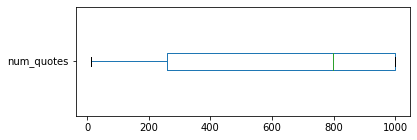

In [94]:
# horizontal boxplot of a dataframe column
cat_df[['num_quotes']].plot(kind='box', vert=False, figsize=(6, 2));

# Data cleaning and refactoring


In [110]:
# clean quotes for special characters and other 
def preprocess(rawQuoteText):
    rawQuoteText = rawQuoteText.str.replace("(<br/>)", '')
    rawQuoteText = rawQuoteText.str.replace('(<a).*(>).*(</a>)', '')
    rawQuoteText = rawQuoteText.str.replace('(&amp)', '')
    rawQuoteText = rawQuoteText.str.replace('(&gt)', '')
    rawQuoteText = rawQuoteText.str.replace('(&lt)', '')
    rawQuoteText = rawQuoteText.str.replace('(\xa0)', ' ')
    rawQuoteText = rawQuoteText.str.replace('"', '')
    rawQuoteText = rawQuoteText.str.replace("'", '') 
    return rawQuoteText

rawDf['quote'] = preprocess(rawDf['quote'])
rawDf.head()

,quote,label
0,Age is an issue of mind over matter. If you do...,age
1,Anyone who stops learning is old whether at tw...,age
2,Wrinkles should merely indicate where smiles h...,age
3,True terror is to wake up one morning and disc...,age
4,A diplomat is a man who always remembers a wom...,age


In [111]:
# drop some labels for quote categories i am not interested in
all_labels = rawDf.label.unique()
keep = ['amazing','art', 'attitude', 'beauty', 'best','business','change','communication','cool', 'courage','design','dreams', 'education','equality', 'experience', 'failure', 'family', 'famous', 'fear', 'finance', 'fitness', 'forgiveness', 'freedom', 'friendship', 'future',
       'good','great','happiness', 'health','hope','imagination', 'inspirational', 'intelligence','knowledge', 'leadership', 'learning','life', 'love',
       'money','motivational','movingon','patience','positive', 'power', 'relationship','respect', 'smile', 'society','strength', 'success', 'sympathy',
       'thankful', 'time', 'trust','truth','wisdom','work']
drop = [i for i in all_labels if i not in keep]

# Consolidate remaining quote categories into 5 distinct groups
for item in drop:
    rawDf = rawDf.drop(rawDf.index[rawDf.label == item])

group1 = ['art', 'design', 'education', 'learning', 'knowledge', 'intelligence']
group2 = ['attitude', 'best', 'amazing', 'cool', 'courage',   'good', 'great', 'happiness','hope',  'inspirational','motivational',  'patience', 'positive', 'power','respect', 'smile']
group3 = ['beauty', 'family', 'fitness', 'friendship', 'health', 'love','movingon', 'life','relationship', 'society', 'strength']
group4 = ['work', 'business', 'communication', 'finance', 'leadership', 'money', 'famous', 'success']
group5 = ['change', 'equality', 'fear', 'dreams', 'experience', 'failure', 'forgiveness', 'freedom','future', 'imagination',  'sympathy', 'thankful', 'time', 'trust', 'truth','wisdom']

# create a list of our conditions
conditions = [
    (rawDf['label'].isin(group1)),
    (rawDf['label'].isin(group2)),
    (rawDf['label'].isin(group3)),
    (rawDf['label'].isin(group4)),
    (rawDf['label'].isin(group5))
    ]

# # create a list of the values we want to assign for each condition
label_cols = ['thoughtful', 'emotional', 'personal', 'work', 'aspirations']

# create a new column and use np.select to assign values to it using our lists as arguments
rawDf['label2'] = np.select(conditions, label_cols)

# display updated DataFrame
rawDf.head()

,quote,label,label2
1997,Sometimes I think my husband is so amazing tha...,amazing,emotional
1998,If you tell people where to go but not how to ...,amazing,emotional
1999,It is amazing what you can accomplish if you d...,amazing,emotional
2000,If you set goals and go after them with all th...,amazing,emotional
2001,Nobody in life gets exactly what they thought ...,amazing,emotional


In [112]:
# keep new labels
rawDf.drop(columns="label", inplace=True)
rawDf = rawDf.rename(columns={"label2": "label"})

In [113]:
# Save cleaned quotes as new csv file
rawDf.to_csv (f'{INPUT_DIR}QuotesClean.csv', index = False, header=True)

# Balance Quote Categories

In [114]:
# find average number of quotes in a group
per_cat_count = rawDf.groupby('label').count().reset_index()
average_count = int(per_cat_count.mean())
average_count

8406

In [115]:
# save counts as a list 
counts = [j['quote'] for i,j in per_cat_count.iterrows()]
sum(counts)

42030

In [116]:
# get count of quotes per category
for i, j in per_cat_count.iterrows(): 
    print(f"{j['label']} | {j['quote']}")  

aspirations | 11478
emotional | 11406
personal | 8379
thoughtful | 5049
work | 5718


In [117]:
"""
aspirations | 11478
emotional | 11406
personal | 8379
thoughtful | 5049
work | 5718

Upsample the three minority classes and downsample the two majority classes to average number. 
So ending total number of quotes is the same but groups are balanced 

"""

seed = 895

# Separate majority and minority classes
df_majority1 = rawDf[rawDf.label=='aspirations']
df_majority2 = rawDf[rawDf.label=='emotional']
df_minority1 = rawDf[rawDf.label=='thoughtful']
df_minority2 = rawDf[rawDf.label=='work']
df_middle = rawDf[rawDf.label=='personal']
 
# Upsample minority classes
df_minority1_upsampled = resample(df_minority1, 
                                 replace=True,     # sample with replacement
                                 n_samples=average_count,    # to match middle class
                                 random_state=seed) # reproducible results

df_minority2_upsampled = resample(df_minority2, 
                                 replace=True,     # sample with replacement
                                 n_samples=average_count,    # to match middle class
                                 random_state=seed) # reproducible results

df_middle_upsampled = resample(df_middle, 
                                 replace=True,     # sample with replacement
                                 n_samples=average_count,    # to match middle class
                                 random_state=seed) # reproducible results

# Downsample majority classes
df_majority1_downsampled = resample(df_majority1, 
                                 replace=False,    # sample without replacement
                                 n_samples=average_count,    # to match middle class
                                 random_state=seed) # reproducible results

df_majority2_downsampled = resample(df_majority2, 
                                 replace=False,    # sample without replacement
                                 n_samples=average_count,    # to match middle class
                                 random_state=seed) # reproducible results


# Combine middle class with upsampled and downsamples classes
dfBalanced = pd.concat([df_middle_upsampled, df_minority1_upsampled, df_minority2_upsampled, df_majority1_downsampled, df_majority2_downsampled])
 
# Display new class counts
# get count of quotes per category
balanced_cat_count = dfBalanced.groupby('label').count().reset_index()
for i, j in balanced_cat_count.iterrows(): 
    print(f"{j['label']} | {j['quote']}") 

aspirations | 8406
emotional | 8406
personal | 8406
thoughtful | 8406
work | 8406


In [118]:
# Export as a new cvs the balanced dataset 
dfBalanced.to_csv (f'{INPUT_DIR}BalancedQuotesClean.csv', index = False, header=True)

In [130]:
# View a sample of 5 quotes
tes = [item for item in dfBalanced['quote'].sample(5)]
tes

['The best thing about acting is that I get to lose myself in another character and actually get paid for it... Its a great outlet. Im not really sure who I am - it seems I change every day.',
 'This also turned out to be negative so there is no material in the Central Intelligence Agency either in the records or in the mind of any of the individuals that there was any contact had or even contemplated with him.',
 'Yes you must have the courage of being free.',
 'Friendship... is not something you learn in school. But if you havent learned the meaning of friendship you really havent learned anything.',
 'Without pain there would be no suffering without suffering we would never learn from our mistakes. To make it right pain and suffering is the key to all windows without it there is no way of life.']